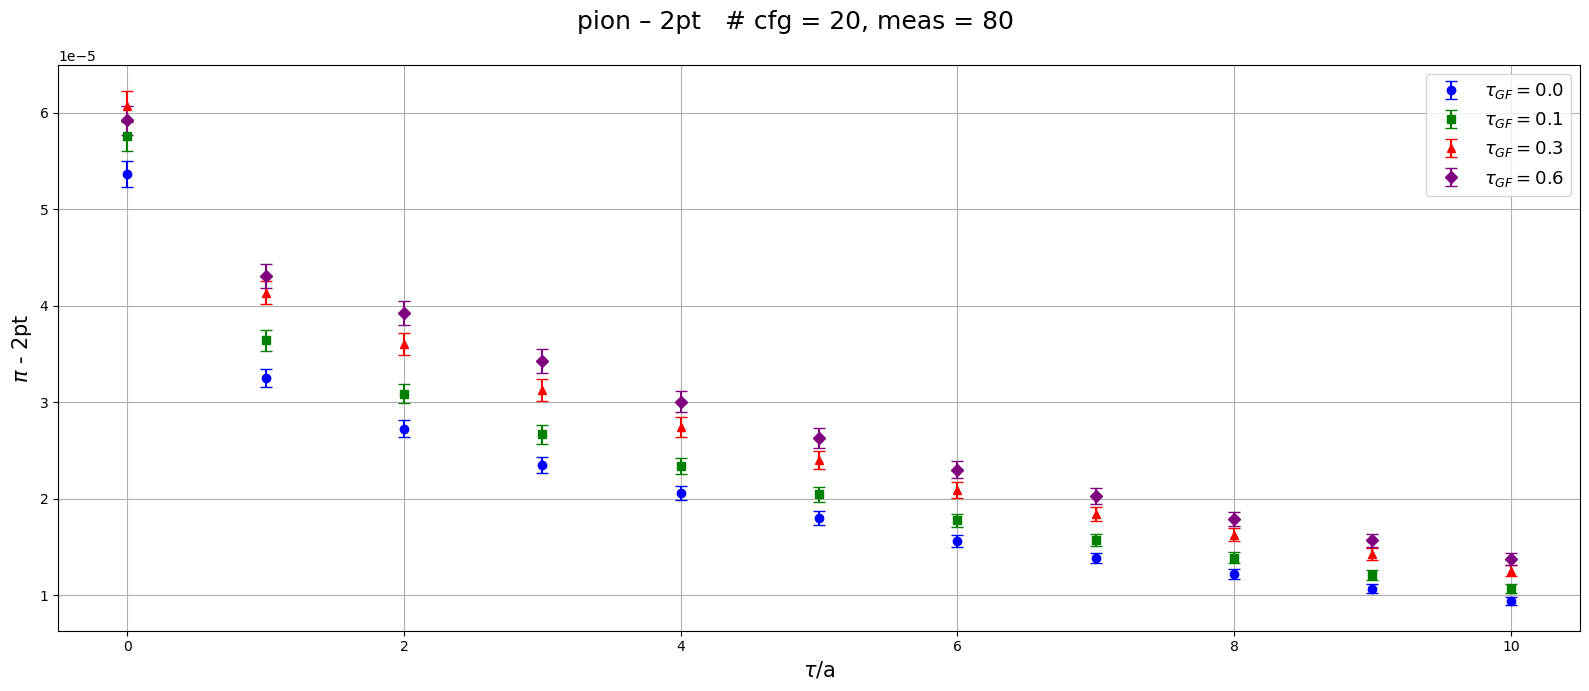

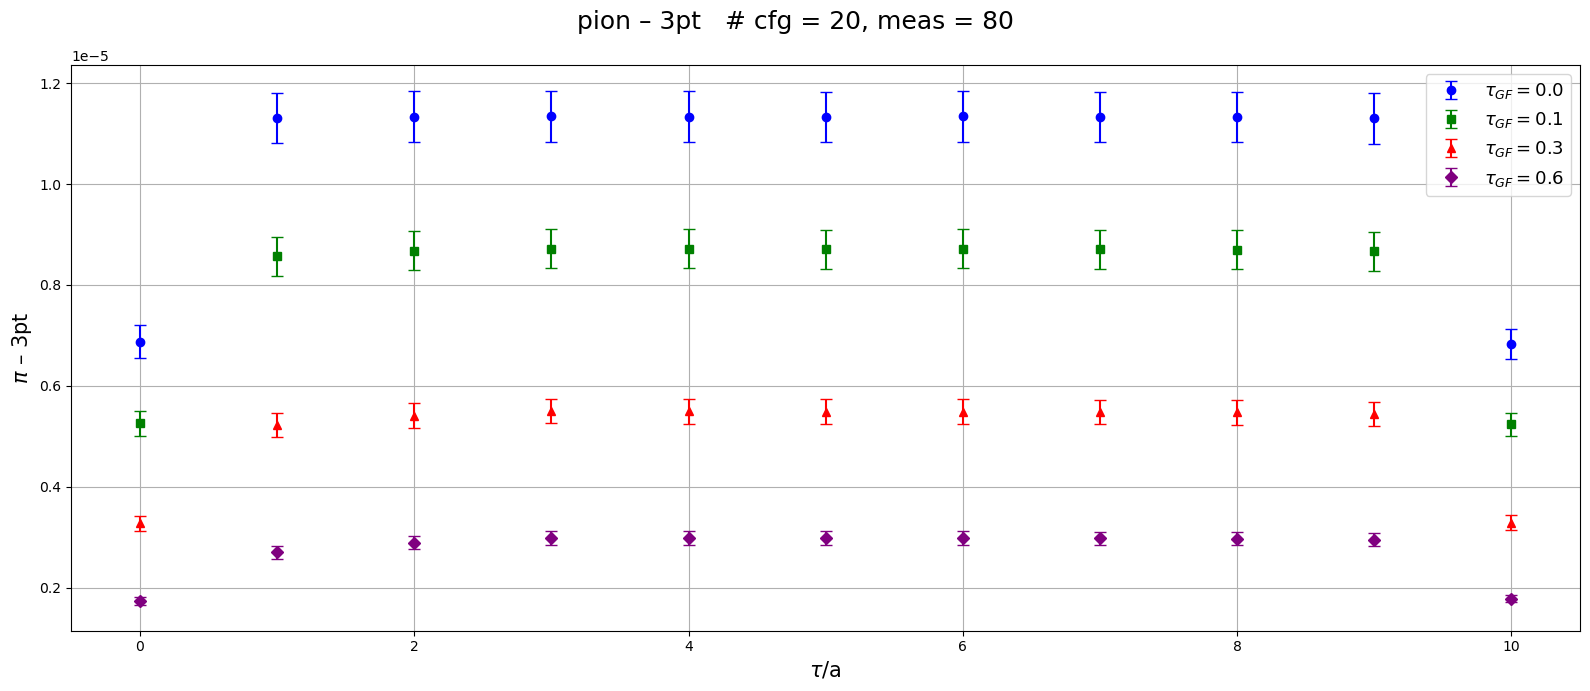

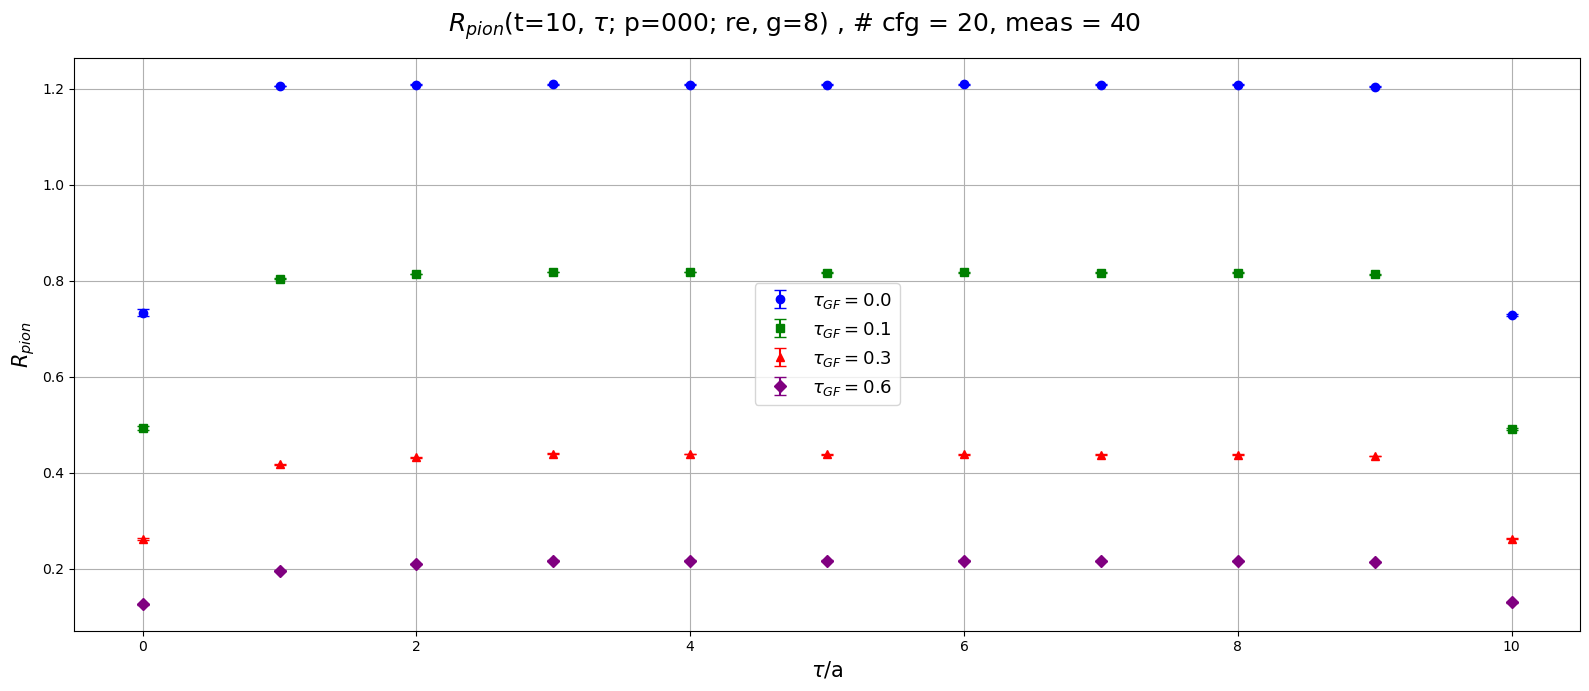

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))


cfglist =[12000, 18440, 18470, 18500, 18530, 18560, 18590, 18620, 18650, 18680, 18710, 18740, 18770, 18800, 18830, 18860, 18890, 18920, 18950, 19010]
def plot_all_flows(Gn, Num, snk_time, cfglist):
    flow_times = ["0p0", "0p1", "0p3", "0p6"]
    tau_GF = [0.0, 0.1, 0.3, 0.6]
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's', '^', 'D']

    fig1, ax1 = plt.subplots(figsize=(16,7))
    fig2, ax2 = plt.subplots(figsize=(16,7))
    fig3, ax3 = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        pt2_cfg = []
        #pt2_cfgfull = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
        
            U_file_path = f"/pscratch/sd/h/hari_8/nEDM_project_LANL/output_3pt2pt_flow/WF{WFt}_pion3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
                U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
                U_values = U_observable_cfgb[Num][()]
            
            U_pt3_data = np.array(U_values)
            U_pt3_data1 = U_pt3_data[28:(28+(snk_time+1))]
            U_pt3_data2 = U_pt3_data[60:(60+(snk_time+1))]
            U_pt3_data3 = U_pt3_data[92:(92+(snk_time+1))]
            U_pt3_data4 = np.concatenate((U_pt3_data[124:], U_pt3_data[0:(snk_time + 1 - (len(U_pt3_data) - 124))]))
            U_pt3_cfg.append((U_pt3_data1+U_pt3_data2+U_pt3_data3+U_pt3_data4)/4)
        
            
            # Load 2pt data
            
            pt2_file_path = "/pscratch/sd/h/hari_8/nEDM_project_LANL/output_3pt2pt_flow/hadspec.h5"
        
            with h5py.File(pt2_file_path, "r") as h5_file: 
                pt2_path_to_observable_cfgb = f"//pion.D-2389.DG7_1.DG7_1.SS/{WFt}_had_{cfg}"
                pt2_observable_cfgb = h5_file[pt2_path_to_observable_cfgb]
                pt2_values = pt2_observable_cfgb[Num][()]
            pt2_data = np.array(pt2_values)
            pt2_data1 = pt2_data[28-28:(28-28+(snk_time+1))]
            pt2_data2 = pt2_data[60-28:(60-28+(snk_time+1))]
            pt2_data3 = pt2_data[92-28:(92-28+(snk_time+1))]
            pt2_data4 = pt2_data[124-28:(124-28+(snk_time+1))]
            pt2_cfg.append((pt2_data1+pt2_data2+pt2_data3+pt2_data4)/4)
            #pt2_cfgfull.append(pt2_data)

        # Compute jackknife
        
        pt2_jackknifeset = Jackknifeset([pt2_cfg[i][(snk_time)] for i in range(len(pt2_cfg))])
        
        pt3bypt2_JK_value = []
        pt3bypt2_JK_err = []
        pt3_JK_value = []
        pt3_JK_err = []
        pt2_JK_value = []
        pt2_JK_err = []
        #for tt in range(128):
        #    pt2_tau_Jackknifeset = Jackknifeset([pt2_cfgfull[i][tt] for i in range(len(pt2_cfgfull))])
        #    pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))
        #    pt2_JK_value.append(pt2_JK_value_err[0])
        #    pt2_JK_err.append(pt2_JK_value_err[1])
            
        for tau in range(snk_time+1):
            U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][tau] for i in range(len(U_pt3_cfg))])
            pt2_tau_Jackknifeset = Jackknifeset([pt2_cfg[i][tau] for i in range(len(pt2_cfg))])
            UDby2pt = (np.array(U_tau_Jackknifeset)) / np.array(pt2_jackknifeset)
            pt3bypt2_JK_value_err = Jackknife(UDby2pt)
            UD = (np.array(U_tau_Jackknifeset))
            pt3_JK_value_err = Jackknife(UD)

            pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))
            
    
            pt3bypt2_JK_value.append(pt3bypt2_JK_value_err[0])
            pt3bypt2_JK_err.append(pt3bypt2_JK_value_err[1])

            pt3_JK_value.append(pt3_JK_value_err[0])
            pt3_JK_err.append(pt3_JK_value_err[1])

            pt2_JK_value.append(pt2_JK_value_err[0])
            pt2_JK_err.append(pt2_JK_value_err[1])


        # Final plot settings
        time_plt = np.arange(len(pt3bypt2_JK_value))
        ax1.errorbar(time_plt, pt2_JK_value, yerr=pt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {tau_GF[i]}$")
        ax2.errorbar(time_plt, pt3_JK_value, yerr=pt3_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {tau_GF[i]}$")
        ax3.errorbar(time_plt, pt3bypt2_JK_value, yerr=pt3bypt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {tau_GF[i]}$")
    ax1.set_xlabel("$\\tau$/a", fontsize=15)
    ax1.set_ylabel("$\pi$ - 2pt", fontsize=15)
    fig1.suptitle(f"pion – 2pt   # cfg = {nocfg}, meas = {nocfg*4}", fontsize=18)
    ax1.tick_params(labelsize=10)
    ax1.grid(True)
    ax1.legend(fontsize=13)
    fig1.tight_layout()
    fig1.savefig(f"pt2_pion_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig1.show()  

    
    
    ax2.set_xlabel("$\\tau$/a", fontsize=15)
    ax2.set_ylabel(r"${\pi}$ – 3pt", fontsize=15)
    fig2.suptitle(f"pion – 3pt   # cfg = {nocfg}, meas = {nocfg*4}", fontsize=18)
    ax2.tick_params(labelsize=10)
    ax2.grid(True)
    ax2.legend(fontsize=13)
    fig2.tight_layout()
    fig2.savefig(f"3pt_pion_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig2.show()

    
    
    ax3.set_xlabel("$\\tau$/a", fontsize=15)
    ax3.set_ylabel(r"$R_{pion}$", fontsize=15)
    fig3.suptitle(
        f"$R_{{pion}}$(t={snk_time}, $\\tau$; p=000; {Num}, g={Gn}) , # cfg = {nocfg}, meas = {nocfg*2}", fontsize=18  )
    ax3.tick_params(labelsize=10)
    ax3.grid(True)
    ax3.legend(fontsize=13)
    fig3.tight_layout()
    fig3.savefig(f"ReG8_pion_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig3.show()


plot_all_flows(8, "re", 10, cfglist)

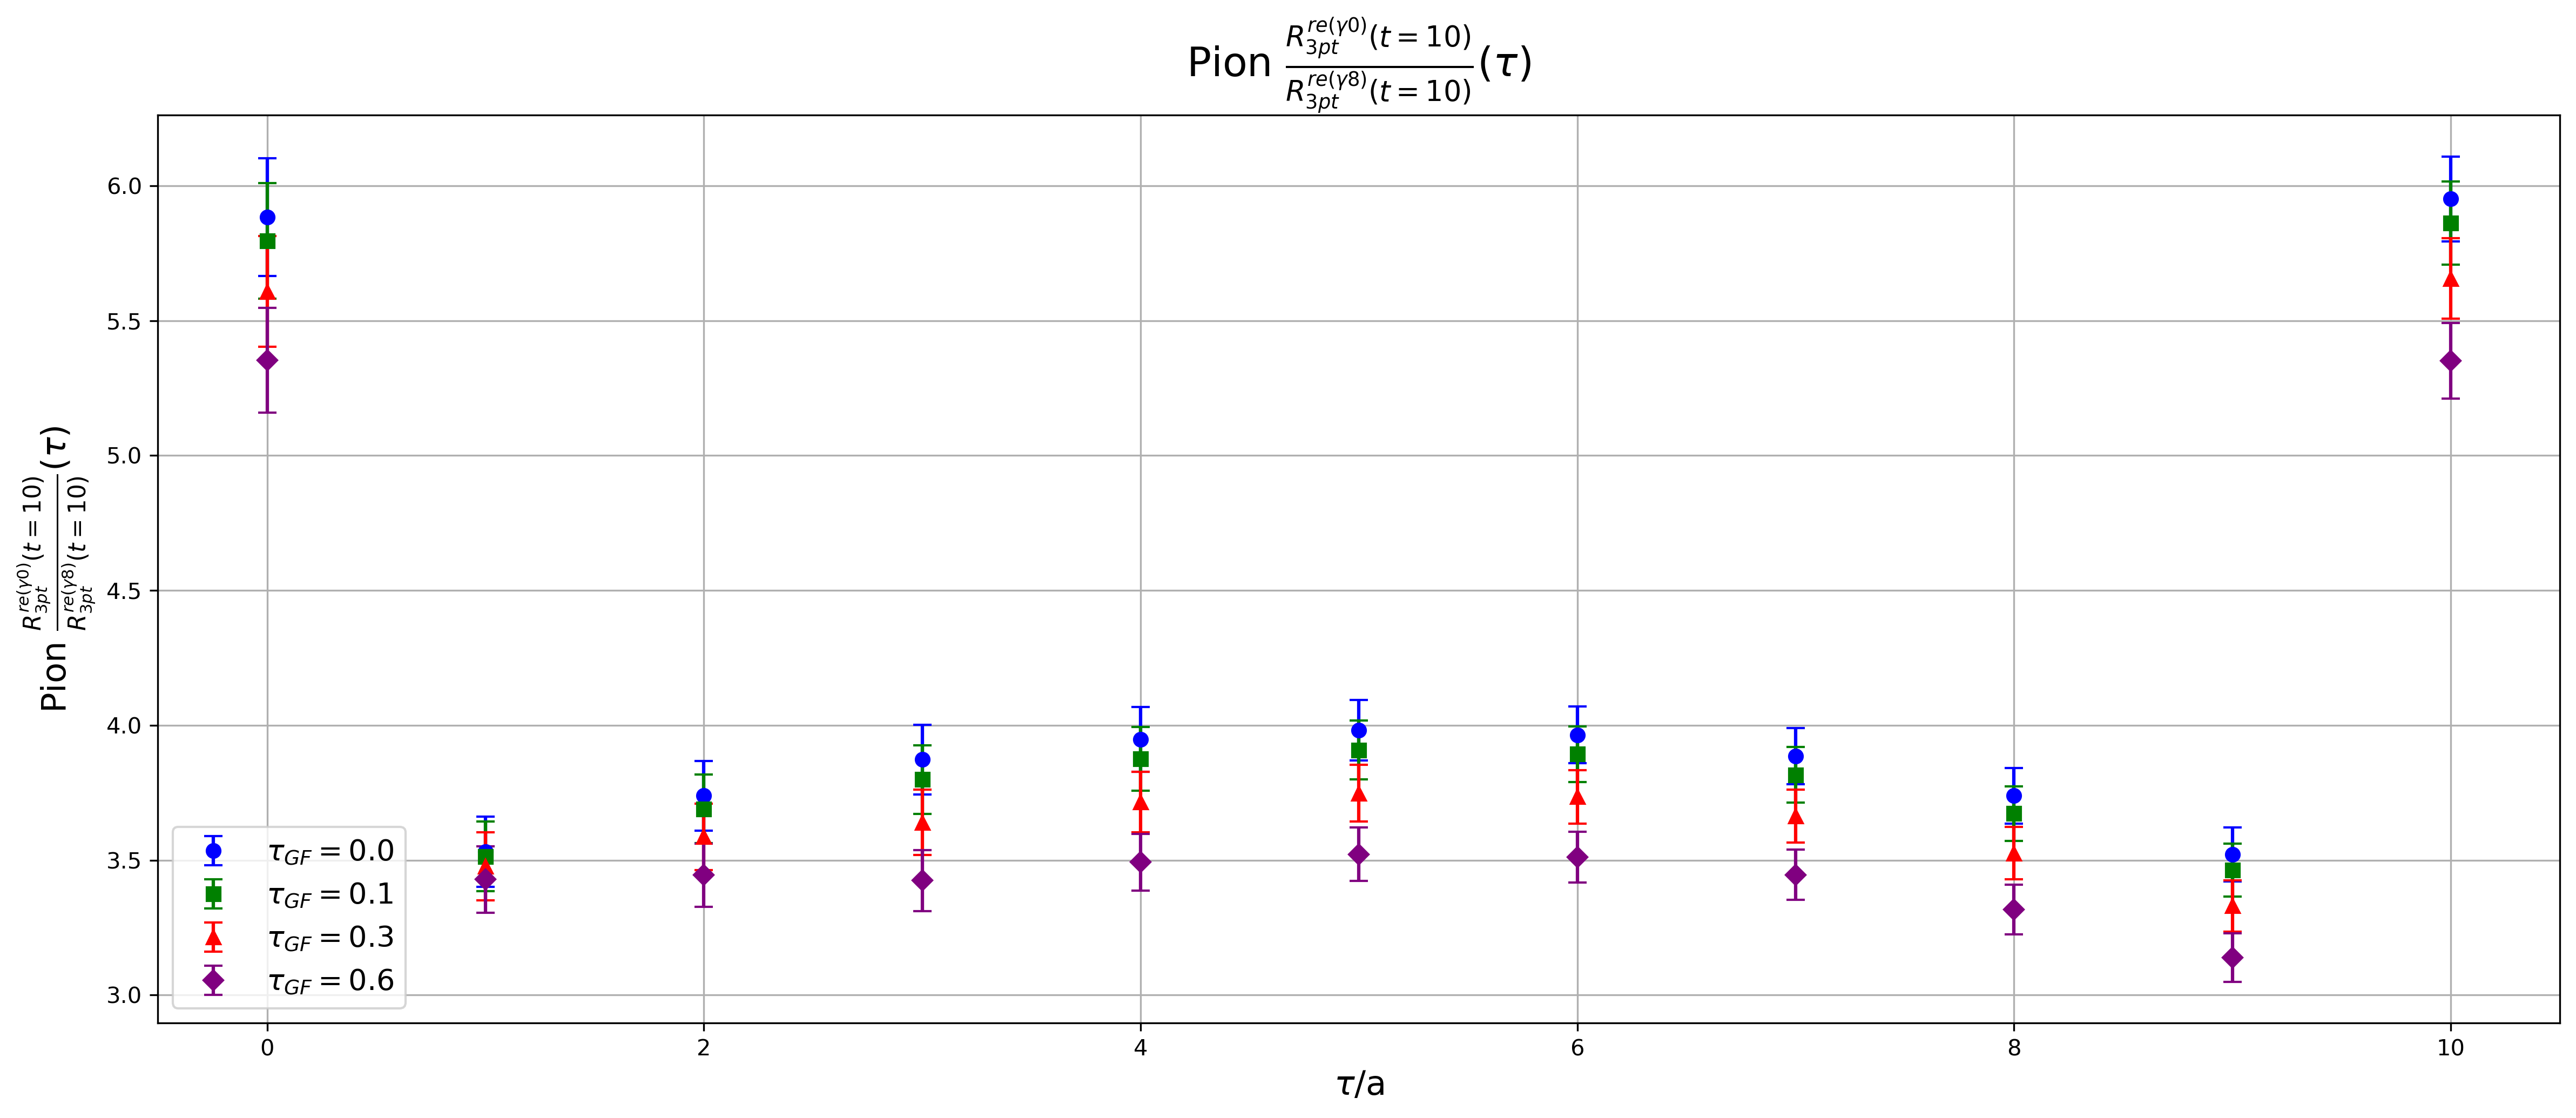

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))


cfglist =[12000, 18440, 18470, 18500, 18530, 18560, 18590, 18620, 18650, 18680, 18710, 18740, 18770, 18800, 18830, 18860, 18890, 18920, 18950, 19010]
def plot3pt3pt_all_flows(Gn1, Num1, Gn2, Num2, snk_time, cfglist):
    flow_times = ["0p0", "0p1", "0p3", "0p6"]
    tau_GF = [0.0, 0.1, 0.3, 0.6]
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's', '^', 'D']

    plt.figure(figsize=(16, 7), dpi=300)

    for i, WFt in enumerate(flow_times):
        # Load 3pt data
        U_1_pt3_cfg = []
        U_2_pt3_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
        
            U_file_path = f"/pscratch/sd/h/hari_8/nEDM_project_LANL/output_3pt2pt_flow/WF{WFt}_pion3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_1_path_to_observable_cfgb = f"//NUCL_l0_g{Gn1}_qz+0_qy+0_qx+0/001"
                U_1_observable_cfgb = h5_file[U_1_path_to_observable_cfgb]
                U_1_values = U_1_observable_cfgb[Num1][()]
                U_2_path_to_observable_cfgb = f"//NUCL_l0_g{Gn2}_qz+0_qy+0_qx+0/001"
                U_2_observable_cfgb = h5_file[U_2_path_to_observable_cfgb]
                U_2_values = U_2_observable_cfgb[Num2][()]
            
            U_1_pt3_data = np.array(U_1_values)
            U_1_pt3_data1 = U_1_pt3_data[28:(28+(snk_time+1))]
            U_1_pt3_data2 = U_1_pt3_data[60:(60+(snk_time+1))]
            U_1_pt3_data3 = U_1_pt3_data[92:(92+(snk_time+1))]
            U_1_pt3_data4 = np.concatenate((U_1_pt3_data[124:], U_1_pt3_data[0:(snk_time + 1 - (len(U_1_pt3_data) - 124))]))
            U_1_pt3_cfg.append((U_1_pt3_data1+U_1_pt3_data2+U_1_pt3_data3+U_1_pt3_data4)/4)

            U_2_pt3_data = np.array(U_2_values)
            U_2_pt3_data1 = U_2_pt3_data[28:(28+(snk_time+1))]
            U_2_pt3_data2 = U_2_pt3_data[60:(60+(snk_time+1))]
            U_2_pt3_data3 = U_2_pt3_data[92:(92+(snk_time+1))]
            U_2_pt3_data4 = np.concatenate((U_2_pt3_data[124:], U_2_pt3_data[0:(snk_time + 1 - (len(U_2_pt3_data) - 124))]))
            U_2_pt3_cfg.append((U_2_pt3_data1+U_2_pt3_data2+U_2_pt3_data3+U_2_pt3_data4)/4)
        
            
    
        
        pt3bypt3_JK_value = []
        pt3bypt3_JK_err = []
        for tau in range(snk_time+1):
            U_1_tau_Jackknifeset = Jackknifeset([U_1_pt3_cfg[i][tau] for i in range(len(U_1_pt3_cfg))])
            U_2_tau_Jackknifeset = Jackknifeset([U_2_pt3_cfg[i][tau] for i in range(len(U_2_pt3_cfg))])
            pt3by3pt = (np.array(U_1_tau_Jackknifeset)) / (np.array(U_2_tau_Jackknifeset))
            pt3bypt3_JK_value_err = Jackknife(pt3by3pt)
            
    
            pt3bypt3_JK_value.append(pt3bypt3_JK_value_err[0])
            pt3bypt3_JK_err.append(pt3bypt3_JK_value_err[1])



        # Final plot settings
        time_plt = np.arange(len(pt3bypt3_JK_value))
        plt.errorbar(time_plt, pt3bypt3_JK_value, yerr=pt3bypt3_JK_err, fmt=markers[i], markersize=6,
                     capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {tau_GF[i]}$")
    plt.xlabel("$\\tau$/a", fontsize=15)
    plt.ylabel("Pion $\\frac{{R^{%s (\\gamma %s) }_{3pt}(t={%s})}}{{R^{%s (\\gamma %s) }_{3pt}(t={%s})}}(\\tau)$"%(Num1, Gn1, snk_time, Num2, Gn2,snk_time), fontsize=15)
    plt.title("Pion $\\frac{{R^{%s (\\gamma %s) }_{3pt}(t={%s})}}{{R^{%s (\\gamma %s) }_{3pt}(t={%s})}}(\\tau)$"%(Num1, Gn1, snk_time, Num2, Gn2,snk_time), fontsize=18)
    plt.legend(fontsize=13)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"g{Gn1}{Num1}byg{Gn2}{Num2}ratio__ud_nucleon_all_flows_t{snk_time}.pdf", dpi=500)
    plt.show()


plot3pt3pt_all_flows(0, "re",8, "re", 10, cfglist)

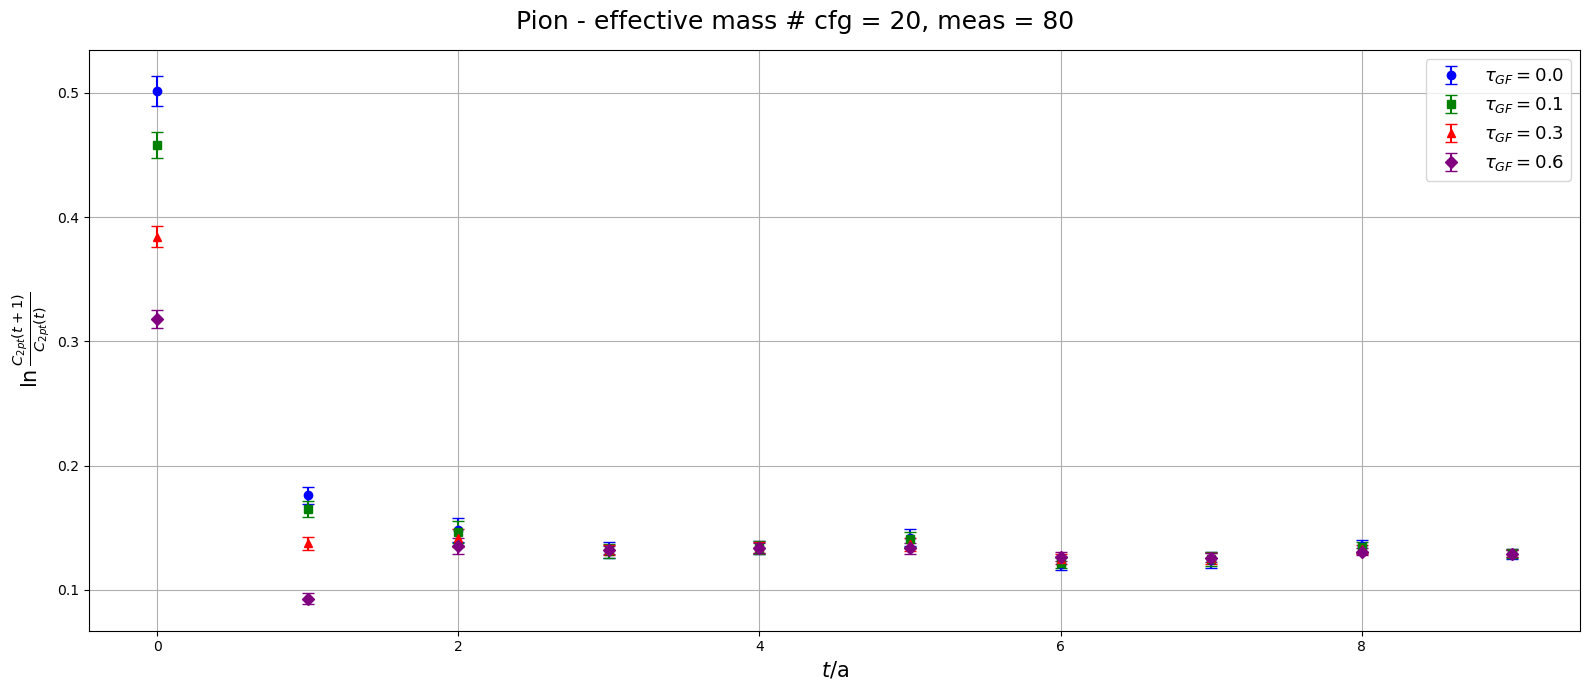

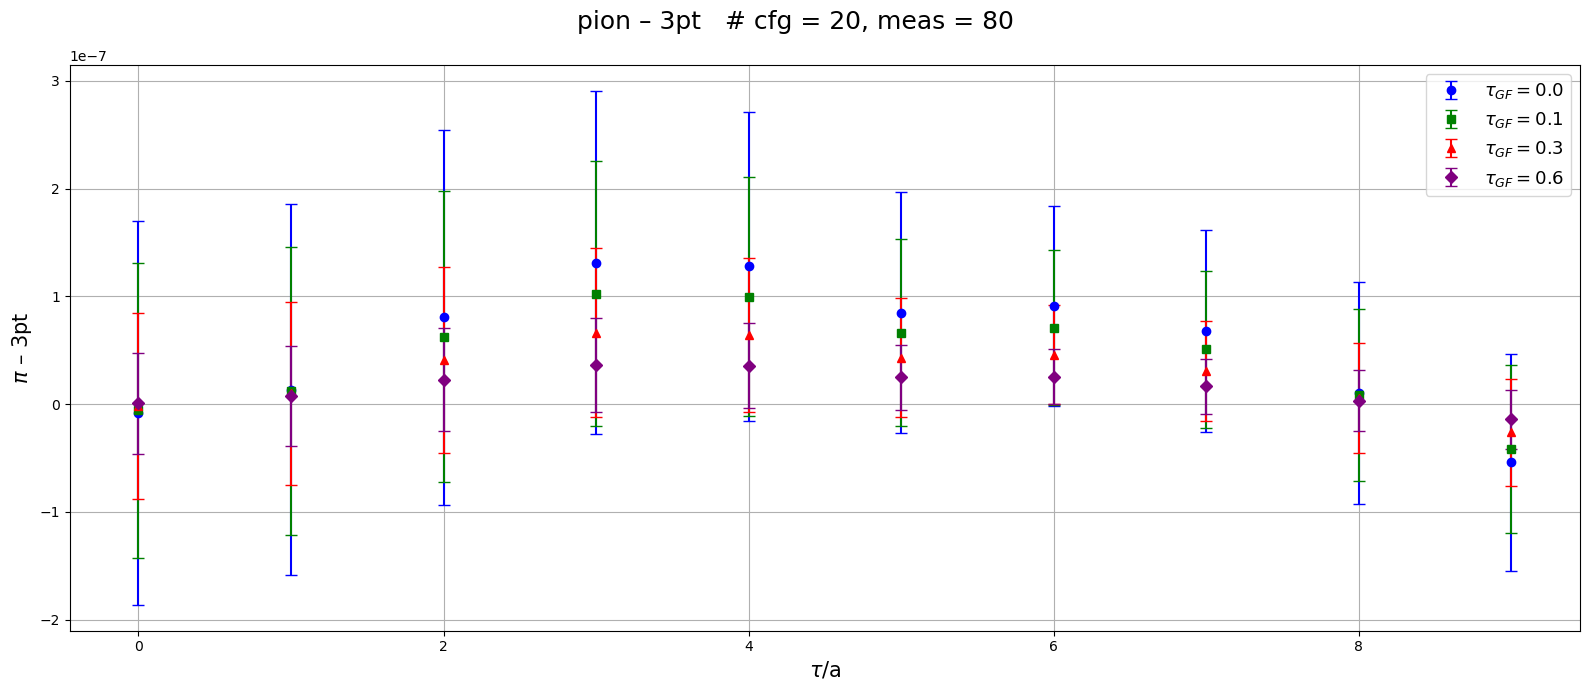

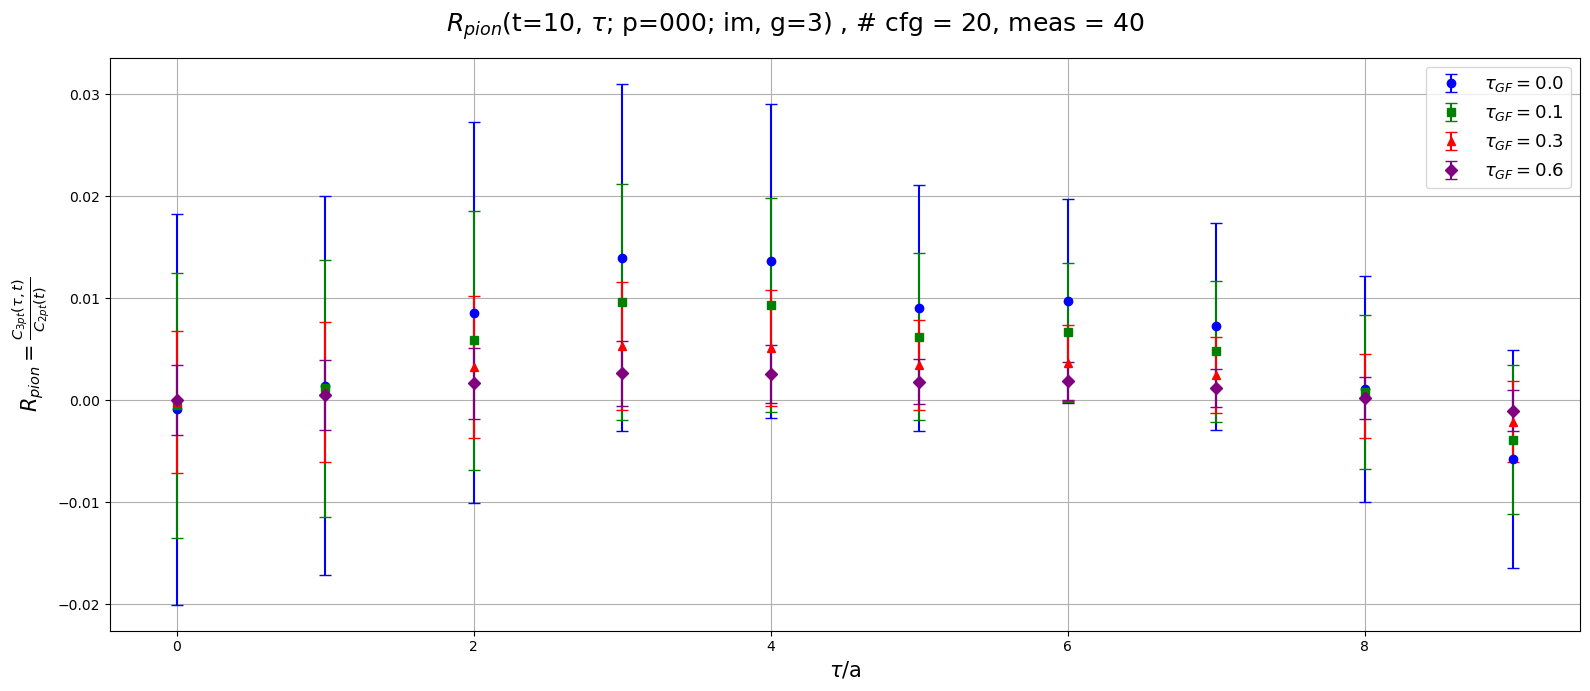

In [31]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))


cfglist =[12000, 18440, 18470, 18500, 18530, 18560, 18590, 18620, 18650, 18680, 18710, 18740, 18770, 18800, 18830, 18860, 18890, 18920, 18950, 19010]
def plot_all_flows(Gn, Num, snk_time, cfglist):
    flow_times = ["0p0", "0p1", "0p3", "0p6"]
    tau_GF = [0.0, 0.1, 0.3, 0.6]
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's', '^', 'D']

    fig1, ax1 = plt.subplots(figsize=(16,7))
    fig2, ax2 = plt.subplots(figsize=(16,7))
    fig3, ax3 = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        pt2_cfg = []
        #pt2_cfgfull = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
        
            U_file_path = f"/pscratch/sd/h/hari_8/nEDM_project_LANL/output_3pt2pt_flow/WF{WFt}_pion3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
                U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
                U_values = U_observable_cfgb[Num][()]
            
            U_pt3_data = np.array(U_values)
            U_pt3_data1 = U_pt3_data[28:(28+(snk_time+1))]
            U_pt3_data2 = U_pt3_data[60:(60+(snk_time+1))]
            U_pt3_data3 = U_pt3_data[92:(92+(snk_time+1))]
            U_pt3_data4 = np.concatenate((U_pt3_data[124:], U_pt3_data[0:(snk_time + 1 - (len(U_pt3_data) - 124))]))
            U_pt3_cfg.append((U_pt3_data1+U_pt3_data2+U_pt3_data3+U_pt3_data4)/4)
        
            
            # Load 2pt data
            
            pt2_file_path = "/pscratch/sd/h/hari_8/nEDM_project_LANL/output_3pt2pt_flow/hadspec.h5"
        
            with h5py.File(pt2_file_path, "r") as h5_file: 
                pt2_path_to_observable_cfgb = f"//pion.D-2389.DG7_1.DG7_1.SS/{WFt}_had_{cfg}"
                pt2_observable_cfgb = h5_file[pt2_path_to_observable_cfgb]
                pt2_values = pt2_observable_cfgb["re"][()]
            pt2_data = np.array(pt2_values)
            pt2_data1 = pt2_data[28-28:(28-28+(snk_time+1))]
            pt2_data2 = pt2_data[60-28:(60-28+(snk_time+1))]
            pt2_data3 = pt2_data[92-28:(92-28+(snk_time+1))]
            pt2_data4 = pt2_data[124-28:(124-28+(snk_time+1))]
            pt2_cfg.append((pt2_data1+pt2_data2+pt2_data3+pt2_data4)/4)
            #pt2_cfgfull.append(pt2_data)

        # Compute jackknife
        
        pt2_jackknifeset = Jackknifeset([pt2_cfg[i][(snk_time)] for i in range(len(pt2_cfg))])
        
        pt3bypt2_JK_value = []
        pt3bypt2_JK_err = []
        pt3_JK_value = []
        pt3_JK_err = []
        pt2_JK_value = []
        pt2_JK_err = []
        #for tt in range(128):
        #    pt2_tau_Jackknifeset = Jackknifeset([pt2_cfgfull[i][tt] for i in range(len(pt2_cfgfull))])
        #    pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))
        #    pt2_JK_value.append(pt2_JK_value_err[0])
        #    pt2_JK_err.append(pt2_JK_value_err[1])
            
        for tau in range(snk_time):
            U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][tau] for i in range(len(U_pt3_cfg))])
            pt2_tau_Jackknifeset_t = Jackknifeset([pt2_cfg[i][tau] for i in range(len(pt2_cfg))])
            pt2_tau_Jackknifeset_t1 = Jackknifeset([pt2_cfg[i][tau+1] for i in range(len(pt2_cfg))])
            pt2_tau_Jackknifeset = np.log(pt2_tau_Jackknifeset_t)-np.log(pt2_tau_Jackknifeset_t1)
            UDby2pt = (np.array(U_tau_Jackknifeset)) / np.array(pt2_jackknifeset)
            pt3bypt2_JK_value_err = Jackknife(UDby2pt)
            UD = (np.array(U_tau_Jackknifeset))
            pt3_JK_value_err = Jackknife(UD)

            pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))
            
    
            pt3bypt2_JK_value.append(pt3bypt2_JK_value_err[0])
            pt3bypt2_JK_err.append(pt3bypt2_JK_value_err[1])

            pt3_JK_value.append(pt3_JK_value_err[0])
            pt3_JK_err.append(pt3_JK_value_err[1])

            pt2_JK_value.append(pt2_JK_value_err[0])
            pt2_JK_err.append(pt2_JK_value_err[1])


        # Final plot settings
        time_plt = np.arange(len(pt3bypt2_JK_value))
        ax1.errorbar(time_plt, pt2_JK_value, yerr=pt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {tau_GF[i]}$")
        ax2.errorbar(time_plt, pt3_JK_value, yerr=pt3_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {tau_GF[i]}$")
        ax3.errorbar(time_plt, pt3bypt2_JK_value, yerr=pt3bypt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {tau_GF[i]}$")
    ax1.set_xlabel("$t$/a", fontsize=15)
    ax1.set_ylabel("$\\ln{\\frac{C_{2pt}(t+1)}{C_{2pt}(t)}}$", fontsize=15)
    fig1.suptitle(f"Pion - effective mass # cfg = {nocfg}, meas = {nocfg*4}", fontsize=18)
    ax1.tick_params(labelsize=10)
    ax1.grid(True)
    ax1.legend(fontsize=13)
    fig1.tight_layout()
    fig1.savefig(f"pt2_pion_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig1.show()  

    
    
    ax2.set_xlabel("$\\tau$/a", fontsize=15)
    ax2.set_ylabel(r"${\pi}$ – 3pt", fontsize=15)
    fig2.suptitle(f"pion – 3pt   # cfg = {nocfg}, meas = {nocfg*4}", fontsize=18)
    ax2.tick_params(labelsize=10)
    ax2.grid(True)
    ax2.legend(fontsize=13)
    fig2.tight_layout()
    #fig2.savefig(f"3pt_pion_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig2.show()

    
    
    ax3.set_xlabel("$\\tau$/a", fontsize=15)
    ax3.set_ylabel("$R_{pion}=\\frac{C_{3pt}(\\tau,t)}{C_{2pt}(t)}$", fontsize=15)
    fig3.suptitle(
        f"$R_{{pion}}$(t={snk_time}, $\\tau$; p=000; {Num}, g={Gn}) , # cfg = {nocfg}, meas = {nocfg*2}", fontsize=18  )
    ax3.tick_params(labelsize=10)
    ax3.grid(True)
    ax3.legend(fontsize=13)
    fig3.tight_layout()
    fig3.savefig(f"pion_3pt2pt_{Gn}_{Num}_4meas_80cfg_all_flows_t{snk_time}.pdf", dpi=500)
    fig3.show()



plot_all_flows(3, "im", 10, cfglist)